# OpenLattice Python API tutorial

This notebook shows how to use the open API documentation to interact with the OpenLattice backend, and load and join data for analysis with python.

Following this notebook requires a good understanding of our platform.  For more information, see our [helpsite](https://help.openlattice.com/).  Especially understanding the entity data model will be helpful.  If you find yourself stuck on what propertytypes are, and how they relate to datasets, see our description of [the EDM](https://help.openlattice.com/article/20-the-openlattice-standardized-entity-data-model).

After we've installed the python library for the OL-API, we can load the library, set the basepath and our authentication, and get the client. You can find you jwt token in the [**account page**](https://openlattice.com/gallery/#/home) of your openlattice account

In [1]:
# openlattice library
import openlattice

# other libraries
from pprint import pprint
import seaborn as sns
import pandas as pd
import numpy as np

jwt = "***"

baseurl = 'https://api.openlattice.com'

configuration = openlattice.Configuration()
configuration.host = baseurl
configuration.api_key_prefix['Authorization'] = 'Bearer'
configuration.api_key['Authorization'] = jwt

## Organization of the openlattice-libraries

Our API endpoints are organized by topic.  You can find detailed information on the API-clients and the functions here: https://github.com/Lattice-Works/api-clients/tree/master/python/docs.  

 API | Description | Link to documentation 
 --- | --- | ---------------------
 AuthorizationsApi | all functions related to checking authorizations | https://github.com/Lattice-Works/api-clients/blob/master/python/docs/AuthorizationsApi.md
 DataApi | all functions related to reading data | https://github.com/Lattice-Works/api-clients/blob/master/python/docs/DataApi.md
 DataIntegrationsApi | all functions related to integrating data | https://github.com/Lattice-Works/api-clients/blob/master/python/docs/DataIntegrationsApi.md
 EdmApi | all functions related to the EDM (entity data model) | https://github.com/Lattice-Works/api-clients/blob/master/python/docs/EdmApi.md 
 EntitySetsApi | all functions related to entity sets, including creating and deleting entitysets, getting and setting metadata | https://github.com/Lattice-Works/api-clients/blob/master/python/docs/EntitySetsApi.md
 OrganizationsApi | all functions related to organizations, eg. creating organizations, adding members, dealing with access roles, materializing entitysets | https://github.com/Lattice-Works/api-clients/blob/master/python/docs/OrganizationsApi.md
 PermissionsApi | all functions related to setting permissions | https://github.com/Lattice-Works/api-clients/blob/master/python/docs/PermissionsApi.md
 PrincipalApi | all functions related to principals. | https://github.com/Lattice-Works/api-clients/blob/master/python/docs/PrincipalApi.md
 SearchApi | all functions related to searching: neighbors,... | https://github.com/Lattice-Works/api-clients/blob/master/python/docs/SearchApi.md
 
**Note**: this table is regularly updated and the table here might be incomplete.

When we load the Api-classes, we will be able to use their functions.

In [2]:
edmApi = openlattice.EdmApi(openlattice.ApiClient(configuration))
entitySetsApi = openlattice.EdmApi(openlattice.ApiClient(configuration))
dataApi = openlattice.DataApi(openlattice.ApiClient(configuration))
searchApi = openlattice.SearchApi(openlattice.ApiClient(configuration))

## Browsing the openlattice platform

First, we will take a look at which datasets we have access to, with the function `edmApi.get_all_entity_sets()`.  If you click on that function in the [documentation](https://github.com/Lattice-Works/api-clients/blob/master/python/docs/EntitySetsApi.md#get_all_entity_sets), it shows which parameters should be added. In this case there are no parameters.

From this function, we get back an object of class EntitySet.  In the [documentation](https://github.com/Lattice-Works/api-clients/blob/master/python/docs/EntitySet.md), we can find a description of all properties in an entityset.
The most important properties:
- **contacts:** email address of the contact-person related to this data.
- **description:** a short description of the dataset.
- **entity_type_id:** the entitytype of the entityset.  Every dataset (entityset) is of a specific predefined type in our datamodel.  You can find more information on the entitytypes in our EDM app (https://openlattice.com/edm/), our by using the `EdmApi`-functions.
- **id:** the **unique identifier** of the entityset, which we will use throughout to handle the entityset.
- **name:** the name of the entityset, without spaces and special characters.
- **organization_id:** each entityset is part of an organization. This identifier is of the organization, which can be looked up with the `OrganizationsApi`-functions.
- **title:** the title of the entityset.  This can be more descriptive than than the name.

In [ ]:
all_entity_sets = [x for x in entitySetsApi.get_all_entity_sets() if "Demo: Arrestees" in x.title]
pprint(all_entity_sets[0])

To look deeper at the entitysets, and for example filter the list to see all entityset-names from the Demo-data, and their ID's, we could use a list comprehension:

In [4]:
entity_set_list = [x.name for x in all_entity_sets if "Demo: " in x.title]
print(entity_set_list)

['DemoLocatedAt', 'DemoSubjectOf', 'DemoHas', 'DemoInvolvedIn', 'DemoReleasedBy', 'DemoIncomes', 'DemoVitalSigns', 'DemoChargeEvents', 'DemoChargedWith', 'DemoScheduled', 'DemoFacilities', 'DemoOccurredAt', 'DemoProviders', 'DemoPatients', 'DemoEpisodes', 'DemoHealthConditions', 'DemoEligibleFor', 'DemoEpisodeDetails', 'DemoInsurance', 'DemoArrestedBy', 'DemoReported', 'DemoHousings', 'DemoPersonDetailsHealth', 'DemoSuspectedOf', 'DemoDispatch', 'DemoPresentsFor', 'DemoObservedIn', 'DemoAssessedBy', 'DemoAppointments', 'DemoIncludes', 'DemoTransportedBy', 'DemoRelatedTo', 'DemoAgencies', 'DemoResultsIn', 'DemoBookedIn', 'DemoSubstances', 'DemoUsing', 'DemoEncounters', 'DemoLivesAt', 'Symptoms']


Everything in our database is identified with a Universally Unique Identifier (UUID).  We have a number of functions to query the id, to use in subsequent functions: `entitySetsApi.get_entity_set_id`, `edmApi.get_entity_type_id`, `edmApi.get_property_type_id`.  For example if we want the UUID for the dataset `DemoPatients`, we can use:

In [5]:
entity_set_id = entitySetsApi.get_entity_set_id("DemoPatients")
print(entity_set_id)

2f3afb54-f757-414c-b7c1-0b07c194edad


If we want to know the details of one specific entity set, we could use the function `get_entity_set()`, with as argument the entityset id:

In [6]:
entitySetsApi.get_entity_set(entity_set_id)

{'contacts': ['kim@openlattice.com', 'jason@openlattice.com'],
 'description': 'Patients logged in the OpenLattice healthcare demo data. This '
                'data is artificial and for demonstration purposes only.',
 'entity_type_id': '31cf5595-3fe9-4d3e-a9cf-39355a4b8cab',
 'flags': ['EXTERNAL'],
 'id': '2f3afb54-f757-414c-b7c1-0b07c194edad',
 'linked_entity_sets': [],
 'linking': None,
 'name': 'DemoPatients',
 'organization_id': '1d5aa1f4-4d22-46a5-97cd-dcc6820e7ff8',
 'partitions': [117],
 'title': 'Demo: Patients'}

#### Exercises

Here are a few questions you could answer using the OpenLattice - libraries when browsing around.  

*easy:*
- What is the entity set ID for the entity set "DemoFacilities"
- Who is the contact person for this entity set?

*moderate:* (requires looking at the documentation, can be done using 1 function)

- There is an entity type called `general.person`.  Try finding the entity type ID.
- Load the entity type.
- There are a number of properties in this entity type.  They are stored as their ID's.  Try to transform one of these ID's into the property type name.

- The entity set above belongs to the organization with ID `'1d5aa1f4-4d22-46a5-97cd-dcc6820e7ff8'`.  Which organization is this?

## Load data

Loading an entityset is very straightforward with our libraries, and we can directly load these into pandas.
For example we can load the entityset `DemoArrestees`, and read this into a pandas dataframe.

As above, we *first* want to query the entityset ID, and use this ID to load the data.

In [7]:
entity_set_id = entitySetsApi.get_entity_set_id("DemoArrestees")
print(entity_set_id)

6ca4a13d-db38-4220-ae37-b5cef76f7ccb


**Description of data object:**
When loading the data, a list is returned with objects.  We refer to each of these objects as **entities**: a single datapoint.  The keys in the object are the property types (the column names in data-language), and the values the actual values.  There is always one additional key `openlattice.@id`, which is the entity ID or entity key ID.  We will use this later to join the tables.

**Property multiplicity:**
We make the assumption that a single person can be identified with different properties, like multiple versions of the first name, or even typo's in birthdates.  Therefore, the entities returned are lists.

In [8]:
data = dataApi.load_entity_set_data(entity_set_id)
pprint(data[:2])

[{'nc.PersonBirthDate': ['1976-12-19', '1976-12-09'],
  'nc.PersonEthnicity': ['nonhispanic'],
  'nc.PersonGivenName': ['Nick', 'Nicholas', 'Claas'],
  'nc.PersonRace': ['white'],
  'nc.PersonSex': ['M'],
  'nc.PersonSurName': ['Martinez'],
  'nc.SSN': ['384-85-6524'],
  'nc.SubjectIdentification': ['e238afcb4483b37de0db905e02348765'],
  'openlattice.@id': ['68b20000-0000-0000-8000-00000000fa45']},
 {'nc.PersonBirthDate': ['1944-06-28'],
  'nc.PersonEthnicity': ['nonhispanic'],
  'nc.PersonGivenName': ['Jackie'],
  'nc.PersonRace': ['white'],
  'nc.PersonSex': ['F'],
  'nc.PersonSurName': ['Logan'],
  'nc.SSN': ['152-31-8226'],
  'nc.SubjectIdentification': ['63580bcf0c536bb485c87eaf8a77d43a'],
  'openlattice.@id': ['61be0000-0000-0000-8000-00000000fc4e']}]


Loading the data into a pandas dataframe can be done with one command:

In [9]:
df = pd.DataFrame(data)
df.head()

,nc.PersonEthnicity,nc.SSN,nc.SubjectIdentification,nc.PersonSex,nc.PersonSurName,nc.PersonGivenName,nc.PersonRace,nc.PersonBirthDate,openlattice.@id
0,[nonhispanic],[384-85-6524],[e238afcb4483b37de0db905e02348765],[M],[Martinez],"[Nick, Nicholas, Claas]",[white],"[1976-12-19, 1976-12-09]",[68b20000-0000-0000-8000-00000000fa45]
1,[nonhispanic],[152-31-8226],[63580bcf0c536bb485c87eaf8a77d43a],[F],[Logan],[Jackie],[white],[1944-06-28],[61be0000-0000-0000-8000-00000000fc4e]
2,"[nonhispanic, hispanic]",[777-49-5252],[8d4347ee6d4ce421466119a03ea01cbc],[F],"[Evans, Lane]",[Kim],[white],"[2006-01-25, 2006-02-25]",[7f1e0000-0000-0000-8000-00000000fad3]
3,[hispanic],[252-12-2384],[e1c5db6721d2d420be6f5ab333d77ec0],[F],[Fleming],[Donna],[other],[1994-09-03],[75180000-0000-0000-8000-00000000fbb1]
4,[nonhispanic],[034-72-6042],[a5f873986cc68b7afd109ded4e3ac7bd],[F],"[Wallace, Carroll]","[Michelle, Mickey]",[black],"[1961-07-25, 1960-07-28]",[54840000-0000-0000-8000-00000000fb47]


#### Visualising the distribution of sex using seaborn

Dealing with the property multiplicity is challenging, since we now have multiple values for each property.  Exploding the table (i.e. expand one list into different rows) will put heavy memory-constraints on the table.  The easiest is to unnest the column of interest, **knowing that this will lead to multiple rows per subject**.  We can use the simple function below, to unnest, and then using seaborn to visualise the distribution.

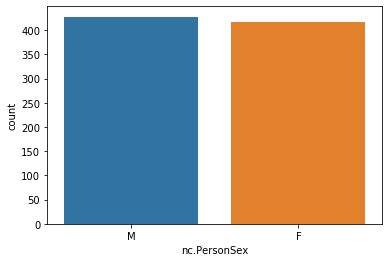

In [10]:
def unnest(df, col):
    unnested = (df.apply(lambda x: pd.Series(x[col]), axis=1)
                .stack()
                .reset_index(level=1, drop=True))
    unnested.name = col
    return df.drop(col, axis=1).join(unnested)

df_sex = unnest(df, "nc.PersonSex")
sns.countplot(x = 'nc.PersonSex', data=df_sex)

#### Exercises:

*easy:*
- Load the data for the entity set `DemoPatients`.
- What is the distribution of `nc.PersonEthnicity` in this entity set?
- How many datapoints are there in this dataset?

## Join Entity Sets

We now load the entity set IDs and the data. First, we decide what data we want.  Let's say we have integrated data from a sheriff's office, supportive housing group, and detox center. We want to look at arrestees and any housing statuses they've given in the past. Use your flight diagrams to decide upon entity sets and relationships and get their names: from your OpenLattice integration, you should have a diagram of the graph data model that your data now resides in. The one for our healthcare demonstration data is [here](https://github.com/Lattice-Works/api-clients/blob/master/examples/demohealth.pdf).

We can see that **DemoPatients -> DemoLivesAt -> DemoHousings** gives us people and any housing status associated with them. 


As in the previous examples, we can load the data using the DataApi.  We can immediately read them into a pandas DataFrame.  Tables are joined through the column `openlattice.@id`, so we do the following:
- get the entity set id (`entitySetsApi.get_entity_set_id()`)
- load the data into a pandas dataframe (`dataApi.load_entity_set_data()`)
- unnest the index column `openlattice.@id` and set the index to this column.

In [11]:
sourceEntitySetId = entitySetsApi.get_entity_set_id('DemoPatients')
src_data = pd.DataFrame(dataApi.load_entity_set_data(sourceEntitySetId))
src_data = unnest(src_data, "openlattice.@id")
src_data = src_data.set_index('openlattice.@id', drop = True).dropna(how='all')


associationEntitySetId = entitySetsApi.get_entity_set_id('DemoLivesAt')
edge_data = pd.DataFrame(dataApi.load_entity_set_data(associationEntitySetId))
edge_data = unnest(edge_data, "openlattice.@id")
edge_data = edge_data.set_index('openlattice.@id', drop = True).dropna(how='all')

destEntitySetId = entitySetsApi.get_entity_set_id('DemoHousings')
dst_data = pd.DataFrame(dataApi.load_entity_set_data(destEntitySetId))
dst_data = unnest(dst_data, "openlattice.@id")
dst_data = dst_data.set_index('openlattice.@id', drop = True).dropna(how='all')

When looking at the data, we can now see the index is correctly set to `openlattice.@id`.

In [12]:
src_data.head()

,nc.PersonEthnicity,nc.SubjectIdentification,nc.PersonSex,nc.PersonSurName,ol.datasource,nc.PersonGivenName,nc.PersonBirthDate,nc.PersonRace
openlattice.@id,,,,,,,,
05b30000-0000-0000-8000-000000003358,[hispanic],[ffce8c91-9c62-4dd5-b640-fdb8ff815eb18],[M],[Hernandez-Lewis],"[Opiate Treatment Program, Someplace Medical C...",[Michael],[1989-05-28],NaN
11c20000-0000-0000-8000-000000003242,[nonhispanic],[4e9b0f1f-1f0a-4346-adaa-8d9475431e1c],[F],[Miller],"[Forest Outpatient Treatment, State Hospital]","[Kimberly, Kim]",[1985-09-22],[asian]
d2500000-0000-0000-8000-00000000326a,[nonhispanic],[aa453c43-cbee-455e-b9ef-0120351ba3be],[M],[Alvarado],[State Hospital],[Charles],"[1941-02-12, 1941-12-02]",NaN
aa0e0000-0000-0000-8000-0000000031f4,NaN,[34822c97-4a6f-4442-90bb-e647a989189f],[F],[Williams],[Anytown Rehabilitation Center],[Melissa],[1972-08-26],[white]
70d20000-0000-0000-8000-00000000328f,[nonhispanic],[2cdd14bc-5a7f-4868-86c1-6b78612f3728],[M],[Beck],"[State Hospital, Anytown Rehabilitation Center]",[Matthew],[1960-11-03],[white]


In [13]:
edge_data.head()

,general.id
openlattice.@id,
312a0000-0000-0000-8000-00000000317a,[ffce8cd1-9c69-4dd5-b640-fdb8ff815eb15_DEPENDE...
b6770000-0000-0000-8000-00000000325e,[ffce8c91-9c69-4dd5-b640-fdb8ff815ex12_HOMELESS]
12de0000-0000-0000-8000-000000003248,[ffce8c91-9c69-4dd5-b620-fdb8ff815eb17_DEPENDE...
e71e0000-0000-0000-8000-0000000031e3,[ffce8c91-9c69-4dd5-b620-fdb8ff815eb16_INDEPEN...
9bcd0000-0000-0000-8000-00000000320c,[523e6174-2a49-4fdb-9ecc-be9d85dfc815_HOMELESS]


In [14]:
dst_data.head()

,ol.id,ol.type
openlattice.@id,,
d5000000-0000-0000-8000-000000003234,[HOMELESS],[HOMELESS]
34490000-0000-0000-8000-0000000032ee,[DEPENDENT LIVING],[DEPENDENT LIVING]
cef20000-0000-0000-8000-0000000032a9,[INDEPENDENT LIVING],[INDEPENDENT LIVING]
74210000-0000-0000-8000-00000000325b,[SOBER HOME],[SOBER HOME]
608b0000-0000-0000-8000-0000000031d0,[RECENTLY INCARCERATED],[RECENTLY INCARCERATED]


## Search the links between the entity sets with the API

### Full search (execute_entity_neighbor_search)

To join two entity sets (through an edge/association) we must find the unique ID that each data point, or entity, has in the three tables: the source, destination, and association. We call these IDs the neighbors.

The `execute_entity_neighbor_search`-function allows us to find all neighbors of an entity.  We can find the neighbors of the first entity in the data with the following arguments:

**note:** `src_data.index` is the index of the table: the entity_keys of this entity set)

In [15]:
all_neighbors = searchApi.execute_entity_neighbor_search(sourceEntitySetId, src_data.index[0])
all_neighbors[10]

{'association_details': {'openlattice.@id': ['cfd40000-0000-0000-8000-0000000032c3']},
 'association_entity_set': {'contacts': ['kim@openlattice.com',
                                         'jason@openlattice.com'],
                            'description': '',
                            'entity_type_id': 'f6f979d0-4eab-46e9-80db-a706dc282fa1',
                            'flags': ['ASSOCIATION', 'EXTERNAL'],
                            'id': '2d89894d-876e-4249-94a7-96118db2d33f',
                            'linked_entity_sets': [],
                            'linking': None,
                            'name': 'DemoObservedIn',
                            'organization_id': '1d5aa1f4-4d22-46a5-97cd-dcc6820e7ff8',
                            'partitions': [130],
                            'title': 'Demo: ObservedIn'},
 'neighbor_details': {'ol.description': ['Anaphylaxis'],
                      'ol.id': ['Anaphylaxis'],
                      'openlattice.@id': ['91650000-0000-

### Filtered search (execute_filtered_entity_neighbor_id_search)

The above approach is very handy of you're looking at 1 row, and you want to find all associated data.  However, often we are interested in joining the full table.  In order to do that, we can use the [filtered entity neighbor id search](https://github.com/Lattice-Works/api-clients/blob/master/python/docs/SearchApi.md#execute_filtered_entity_neighbor_id_search), which will return a table with keys between the two datasets.

With the filtered search, we can be more specific about the source, destination and association. To make such a query, we need to instantiate an object of type `openapi_client.NeighborSearchFilter`.  Note that we will give the source_entity_set_id in the search function, so we leave it as an empty list here in the object.

**Always set the _other_ entity set (whether source or destination) to a blank.**

In [16]:
neighbor_filter = openlattice.NeighborSearchFilter(
    edge = [associationEntitySetId],
    src = [],
    dst = [destEntitySetId],
    entity_key_ids = src_data.index.tolist()
)

Now we can do the filtered search.

In [17]:
neighbor_ids = searchApi.execute_filtered_entity_neighbor_id_search(sourceEntitySetId, neighbor_filter)
# you can call neighbor_ids directly
# >> neighbor_ids
# the hacking below is to render only part of the output

{list(neighbor_ids.keys())[0]: neighbor_ids[list(neighbor_ids.keys())[0]]}

{'11c20000-0000-0000-8000-000000003242': {'668e63bc-a112-460c-8036-00fc3742ae4c': {'0fb7390e-a2b2-4855-ac46-bcce5ced9986': [{'association_id': '98fe0000-0000-0000-8000-0000000031a3',
     'neighbor_id': 'cef20000-0000-0000-8000-0000000032a9',
     'src': True}, {'association_id': '6f8f0000-0000-0000-8000-00000000323c',
     'neighbor_id': 'd5000000-0000-0000-8000-000000003234',
     'src': True}, {'association_id': 'f1a40000-0000-0000-8000-0000000031d3',
     'neighbor_id': '34490000-0000-0000-8000-0000000032ee',
     'src': True}]}}}

What is returned is a complex object, to minimize the data transfer of the network as much as possible.  Wit the following function, you can transform this object in a easy to use pandas table:

In [18]:
def unnest_neighbor_ids(neighbor_ids):
    unnested_object = [{"src": srckey, "edge": neighbor_entity_ids.association_id, "dst": neighbor_entity_ids.neighbor_id}
                 for srckey, srckey_neighbors in neighbor_ids.items()
                 for ass_entset_id, src_ass_neighbors in srckey_neighbors.items()
                 for dst_entset_id, src_ass_dst_neighbors in src_ass_neighbors.items()
                 for neighbor_entity_ids in src_ass_dst_neighbors
                 ]
    unnested_table = pd.DataFrame(unnested_object)
    return unnested_table    

In [19]:
edges_table = unnest_neighbor_ids(neighbor_ids)
edges_table.head()

,src,edge,dst
0,11c20000-0000-0000-8000-000000003242,98fe0000-0000-0000-8000-0000000031a3,cef20000-0000-0000-8000-0000000032a9
1,11c20000-0000-0000-8000-000000003242,6f8f0000-0000-0000-8000-00000000323c,d5000000-0000-0000-8000-000000003234
2,11c20000-0000-0000-8000-000000003242,f1a40000-0000-0000-8000-0000000031d3,34490000-0000-0000-8000-0000000032ee
3,6f940000-0000-0000-8000-00000000321f,fab60000-0000-0000-8000-00000000324c,cef20000-0000-0000-8000-0000000032a9
4,6f940000-0000-0000-8000-00000000321f,78990000-0000-0000-8000-000000003171,d5000000-0000-0000-8000-000000003234


You can always use this function, so you don't need to understand the full object.  However, if you want to understand the returned object for reduced computations, this is what it looks like:

```
{
    <source_entity_id> : 
        {
            <association_entity_set_id>:
                {
                    <destination_entity_set_id>:
                        [
                            {
                                association_id: <association_entity_id>,
                                neighbor_id: <destination_entity_id>,
                                src: True
                            },
                            ...
                        ]
                },
                ...
         }
         ...
    }
```

## Combining the data with the association.

Now we can do left joins on the edges table with the other tables.  For example, we can see that the first person *Kim Miller* has had 3 different housing situations reported.

In [20]:
recombined = edges_table.merge(
    src_data, 
    left_on='src', 
    right_index = True, 
    how="left"
).merge(
    edge_data, 
    left_on='edge', 
    right_index = True, 
    how="left"
).merge(
    dst_data, 
    left_on='dst', 
    right_index = True, 
    how="left"
)

In [21]:
recombined.head(5)

,src,edge,dst,nc.PersonEthnicity,nc.SubjectIdentification,nc.PersonSex,nc.PersonSurName,ol.datasource,nc.PersonGivenName,nc.PersonBirthDate,nc.PersonRace,general.id,ol.id,ol.type
0,11c20000-0000-0000-8000-000000003242,98fe0000-0000-0000-8000-0000000031a3,cef20000-0000-0000-8000-0000000032a9,[nonhispanic],[4e9b0f1f-1f0a-4346-adaa-8d9475431e1c],[F],[Miller],"[Forest Outpatient Treatment, State Hospital]","[Kimberly, Kim]",[1985-09-22],[asian],[4e9b0f1f-1f0a-4346-adaa-8d9475431e1c_INDEPEND...,[INDEPENDENT LIVING],[INDEPENDENT LIVING]
1,11c20000-0000-0000-8000-000000003242,6f8f0000-0000-0000-8000-00000000323c,d5000000-0000-0000-8000-000000003234,[nonhispanic],[4e9b0f1f-1f0a-4346-adaa-8d9475431e1c],[F],[Miller],"[Forest Outpatient Treatment, State Hospital]","[Kimberly, Kim]",[1985-09-22],[asian],[4e9b0f1f-1f0a-4346-adaa-8d9475431e1c_HOMELESS],[HOMELESS],[HOMELESS]
2,11c20000-0000-0000-8000-000000003242,f1a40000-0000-0000-8000-0000000031d3,34490000-0000-0000-8000-0000000032ee,[nonhispanic],[4e9b0f1f-1f0a-4346-adaa-8d9475431e1c],[F],[Miller],"[Forest Outpatient Treatment, State Hospital]","[Kimberly, Kim]",[1985-09-22],[asian],[4e9b0f1f-1f0a-4346-adaa-8d9475431e1c_DEPENDEN...,[DEPENDENT LIVING],[DEPENDENT LIVING]
3,6f940000-0000-0000-8000-00000000321f,fab60000-0000-0000-8000-00000000324c,cef20000-0000-0000-8000-0000000032a9,[nonhispanic],[ffce8c91-9c69-4dd5-b640-fdb8ff815eb12],[F],[Crosby],"[State Hospital, Anytown Rehabilitation Center]",[Cassandra],[1955-08-19],[white],[ffce8c91-9c69-4dd5-b640-fdb8ff815eb12_INDEPEN...,[INDEPENDENT LIVING],[INDEPENDENT LIVING]
4,6f940000-0000-0000-8000-00000000321f,78990000-0000-0000-8000-000000003171,d5000000-0000-0000-8000-000000003234,[nonhispanic],[ffce8c91-9c69-4dd5-b640-fdb8ff815eb12],[F],[Crosby],"[State Hospital, Anytown Rehabilitation Center]",[Cassandra],[1955-08-19],[white],[ffce8c91-9c69-4dd5-b640-fdb8ff815eb12_HOMELESS],[HOMELESS],[HOMELESS]
